In [18]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
pd.options.display.float_format = '{:.6f}'.format

In [20]:
df = pd.read_csv('../data/overall_stats_for_ps4.csv', index_col=0)
df = df.drop(['stats.overall.playtime.secs', 'stats.overall.playtime.mins'], axis=1)
df = df.fillna(0)
print "{} rows".format(df.shape[0])
print "{} columns".format(df.shape[1])
df.head(1).T

131026 rows
20 columns


,25625
stats.overall.assists,1232.000000
stats.overall.barricades_built,2155.000000
stats.overall.bullets_fired,163842.000000
stats.overall.bullets_hit,43493.000000
stats.overall.headshots,1823.000000
stats.overall.melee_kills,55.000000
stats.overall.penetration_kills,525.000000
stats.overall.reinforcements_deployed,6131.000000
stats.overall.revives,165.000000
stats.overall.steps_moved,1136840.000000


In [21]:
df['stats.overall.points'] = df[['stats.overall.assists', 'stats.overall.kills']].sum(1)
defensive_actions = [
    'stats.overall.reinforcements_deployed', 
    'stats.overall.revives', 
    'stats.overall.barricades_built'
]

df['stats.overall.defensive_actions'] = df[defensive_actions].sum(1)
df['stats.overall.engagements'] = df[['stats.overall.kills', 'stats.overall.deaths']].sum(1)

In [22]:
df['stats.normalized.accuracy'] = df['stats.overall.bullets_hit'] / df['stats.overall.bullets_fired']
df['stats.normalized.points.perhour'] = df['stats.overall.points'] / df['stats.overall.playtime.hours']
df['stats.normalized.deaths.perhour'] = df['stats.overall.deaths'] / df['stats.overall.playtime.hours']
df['stats.normalized.kills.perhour'] = df['stats.overall.kills'] / df['stats.overall.playtime.hours']
df['stats.normalized.wins.perhour'] = df['stats.overall.wins'] / df['stats.overall.playtime.hours']
df['stats.normalized.losses.perhour'] = df['stats.overall.losses'] / df['stats.overall.playtime.hours']

df['stats.normalized.defensive_actions.perhour'] = \
    df['stats.overall.defensive_actions'] / df['stats.overall.playtime.hours']

df['stats.normalized.points.perbullet_fired'] = \
    df['stats.overall.points'] / df['stats.overall.bullets_fired']

df['stats.normalized.aggression'] = df['stats.overall.points'] / df['stats.overall.engagements']
df['stats.normalized.mobility'] = df['stats.overall.steps_moved'] / df['stats.overall.engagements']

In [23]:
df = df.fillna(0)
df = df.rename(columns={"stats.overall.wlr": "stats.normalized.wlr", "stats.overall.kd": "stats.normalized.kd"})
df = df.ix[:,df.columns.sort_values()]

In [24]:
feature_cols = df.columns[df.columns.str.contains('normalized')].tolist()
target_cols = ['stats.overall.playtime.hours', 'stats.progression.level', 'stats.progression.xp']

df_gameplay = df.ix[:,feature_cols+target_cols]
df_gameplay.head(1).T

,25625
stats.normalized.accuracy,0.265457
stats.normalized.aggression,0.722953
stats.normalized.deaths.perhour,9.741715
stats.normalized.defensive_actions.perhour,21.066334
stats.normalized.kd,1.471597
stats.normalized.kills.perhour,14.335876
stats.normalized.losses.perhour,1.341106
stats.normalized.mobility,117.697484
stats.normalized.points.perbullet_fired,0.042620
stats.normalized.points.perhour,17.406959


In [25]:
mask = (df_gameplay['stats.normalized.losses.perhour']==0)
df_gameplay[mask].head()

,stats.normalized.accuracy,stats.normalized.aggression,stats.normalized.deaths.perhour,stats.normalized.defensive_actions.perhour,stats.normalized.kd,stats.normalized.kills.perhour,stats.normalized.losses.perhour,stats.normalized.mobility,stats.normalized.points.perbullet_fired,stats.normalized.points.perhour,stats.normalized.wins.perhour,stats.normalized.wlr,stats.overall.playtime.hours,stats.progression.level,stats.progression.xp
430648,0.128186,0.863636,9.506743,24.106385,2.142857,20.371593,0.000000,136.102273,0.019368,25.804018,3.395265,1.000000,2.945278,11.000000,3174.000000
422764,0.152231,0.864865,12.449799,14.056225,1.387097,17.269076,0.000000,126.283784,0.018664,25.702811,2.811245,1.000000,2.490000,9.000000,5374.000000
563225,0.302857,0.987805,5.718176,13.478557,4.857143,27.773996,0.000000,117.158537,0.046286,33.083730,4.901293,1.000000,2.448333,13.000000,2651.000000
303678,0.201161,1.000000,3.327611,23.768652,9.571429,31.849993,0.000000,126.716216,0.030693,35.177605,4.278357,1.000000,2.103611,10.000000,3669.000000
154720,0.142317,0.942308,10.000000,16.521739,1.260870,12.608696,0.000000,162.673077,0.023168,21.304348,2.608696,1.000000,2.300000,8.000000,3680.000000


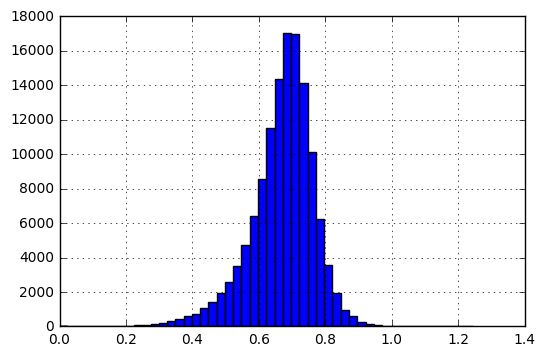

In [26]:
df_gameplay['stats.normalized.aggression'].hist(bins=50)
plt.show()

In [36]:
from sklearn.decomposition import pca
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [37]:
scaler = MinMaxScaler(feature_range=(-1,1), copy=True).fit(df)
# scaler = StandardScaler(copy=True).fit(df)

X_scaled = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

reducer = pca.PCA(n_components=2, whiten=True).fit(X_scaled)
X_pca = pd.DataFrame(reducer.transform(X_scaled), index=df.index, columns=['pca1', 'pca2'])
X_pca.head()

,pca1,pca2
25625,0.761426,0.776237
19782,-0.204793,0.261395
358815,5.996962,-2.307497
610174,-1.080140,-0.903345
86495,-0.544428,-1.002076


In [38]:
X = X_pca.copy().sample(n=10000).values
X

array([[ 0.22188959,  0.19279909],
       [ 5.98495345, -1.12796468],
       [ 0.73333088, -0.7692893 ],
       ..., 
       [-0.55178113,  0.4196139 ],
       [-0.82833812, -0.92277533],
       [ 0.36858271,  0.09166341]])

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

('For n_clusters =', 7, 'The average silhouette_score is :', 0.33979406018742919)


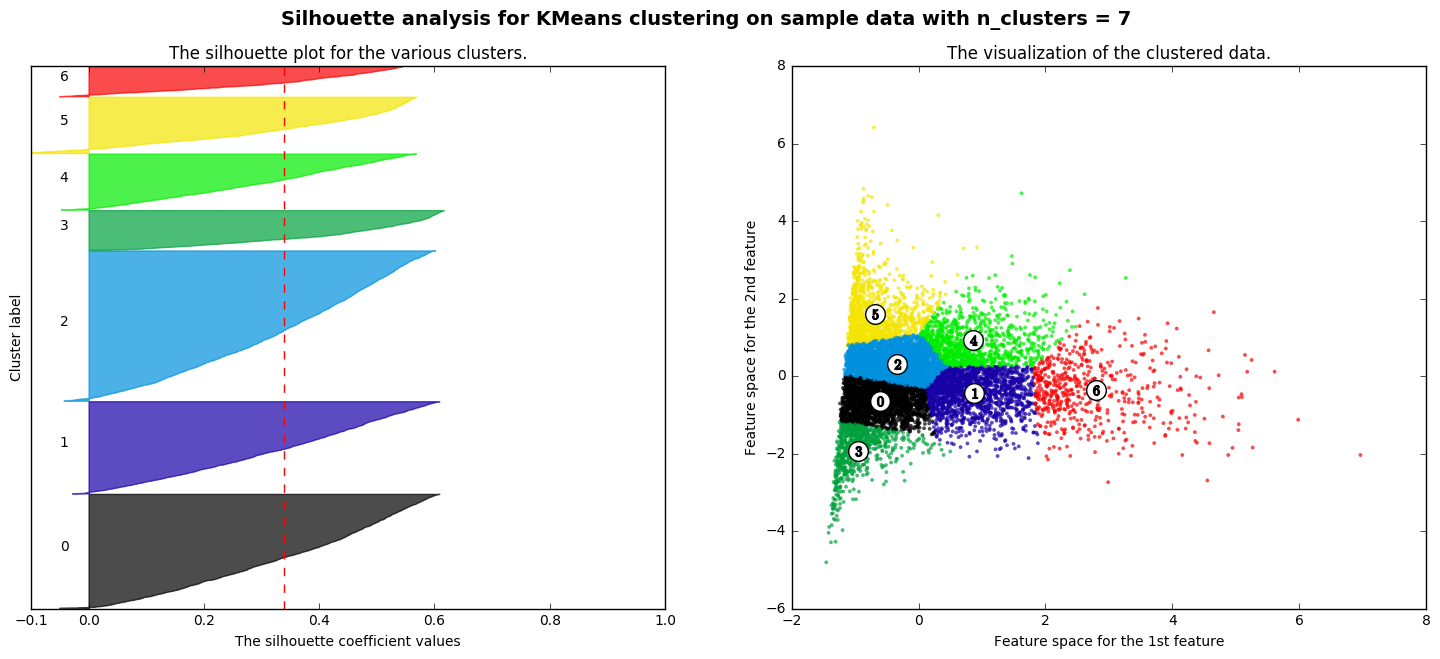

('For n_clusters =', 8, 'The average silhouette_score is :', 0.33887192051347936)


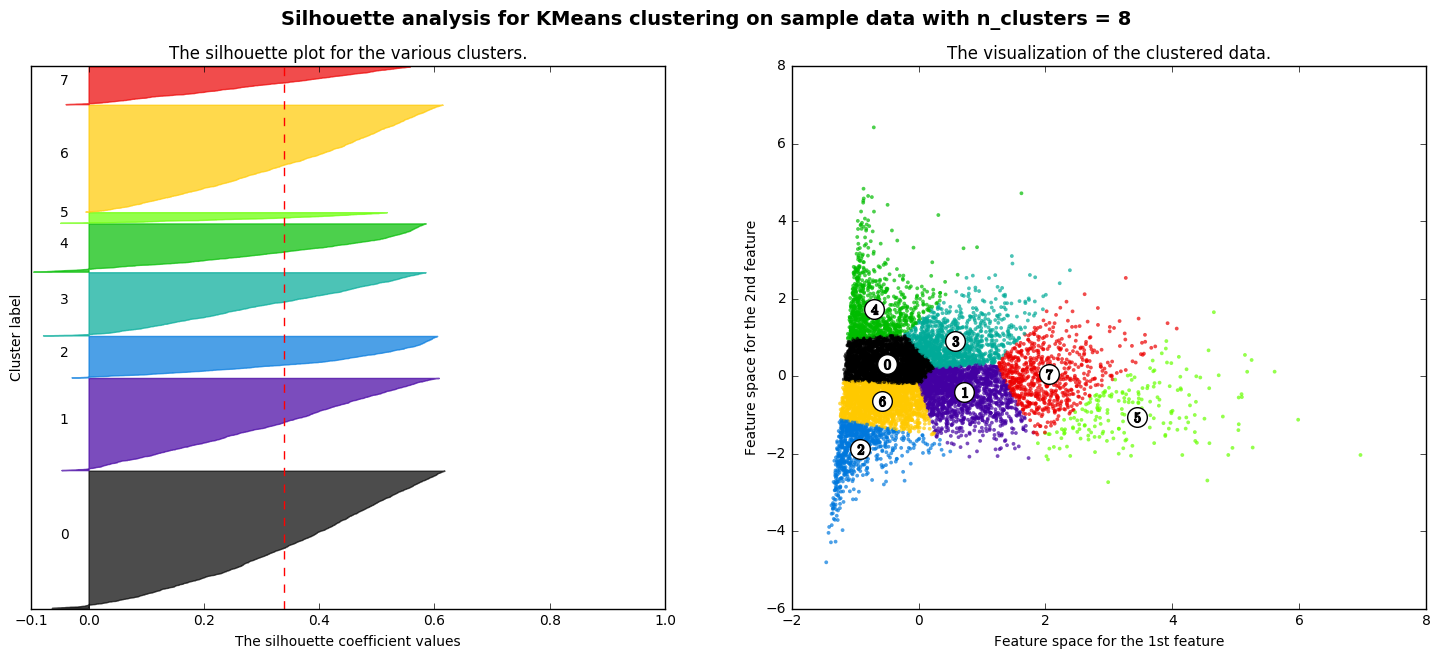

('For n_clusters =', 9, 'The average silhouette_score is :', 0.32340095684193987)


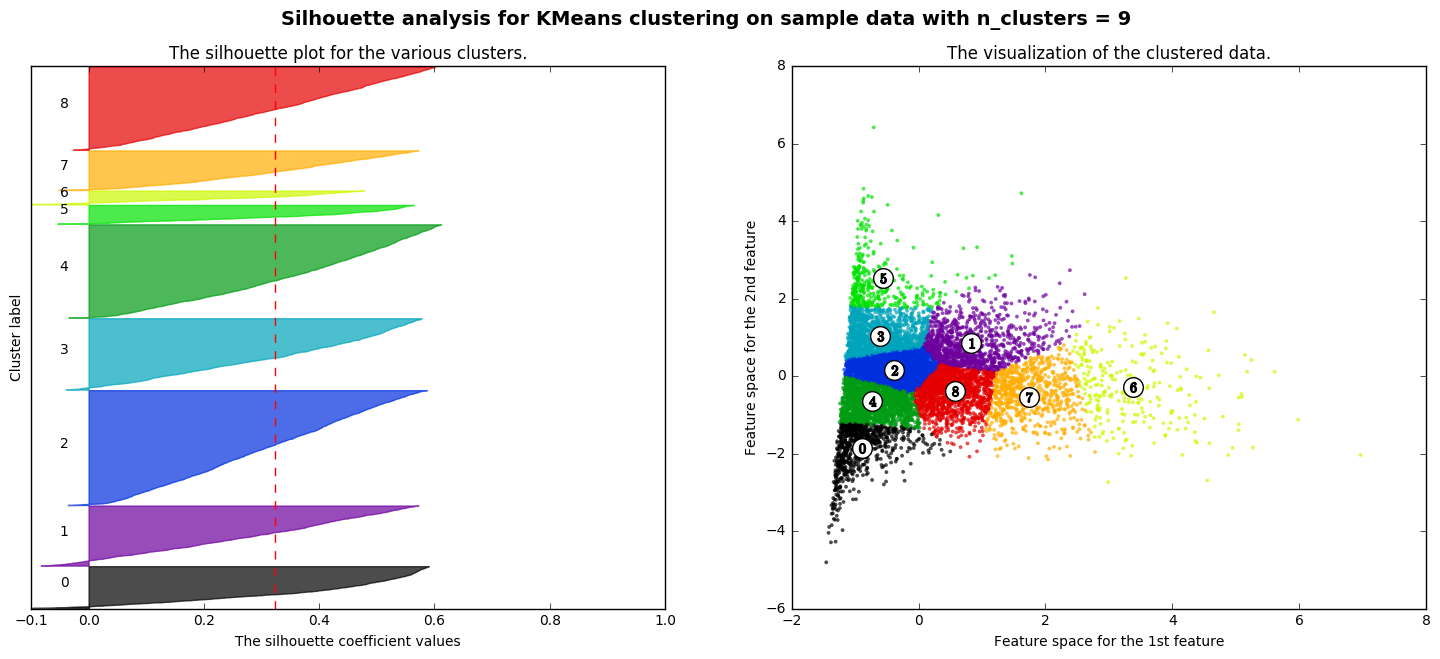

('For n_clusters =', 10, 'The average silhouette_score is :', 0.31276228398217382)


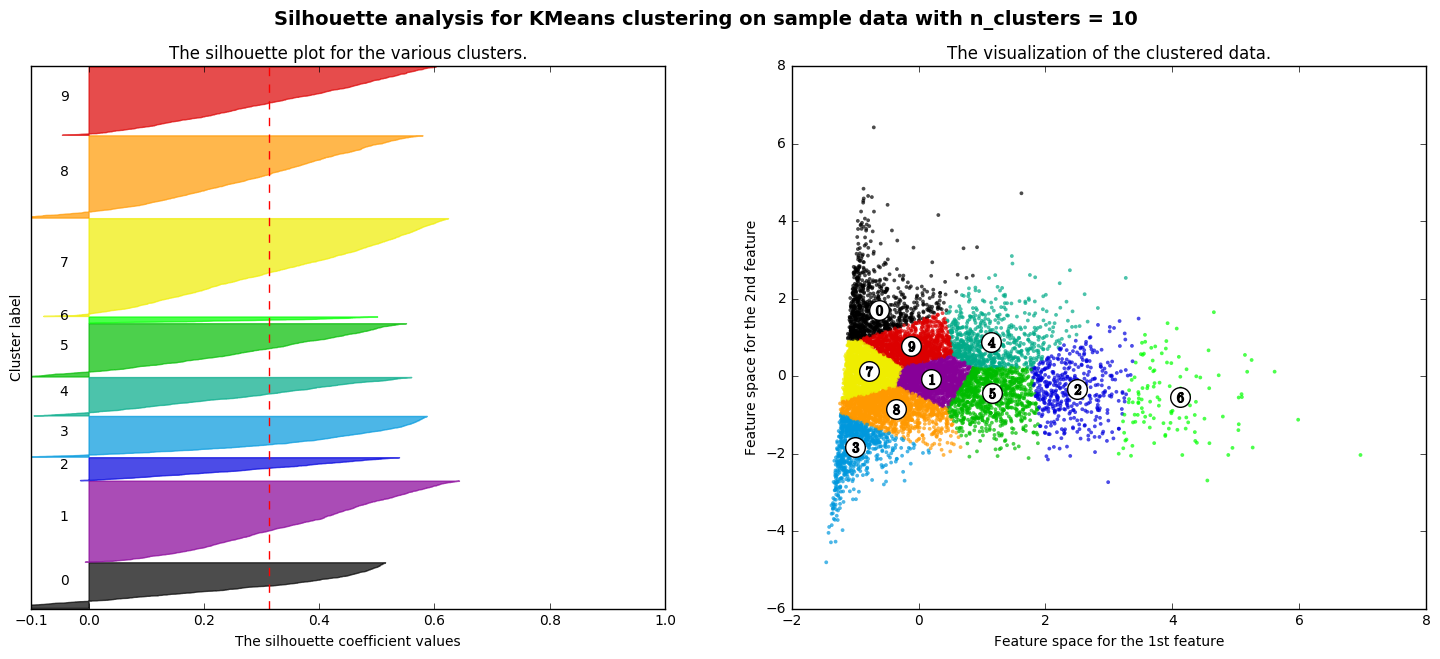

('For n_clusters =', 11, 'The average silhouette_score is :', 0.32481734530439815)


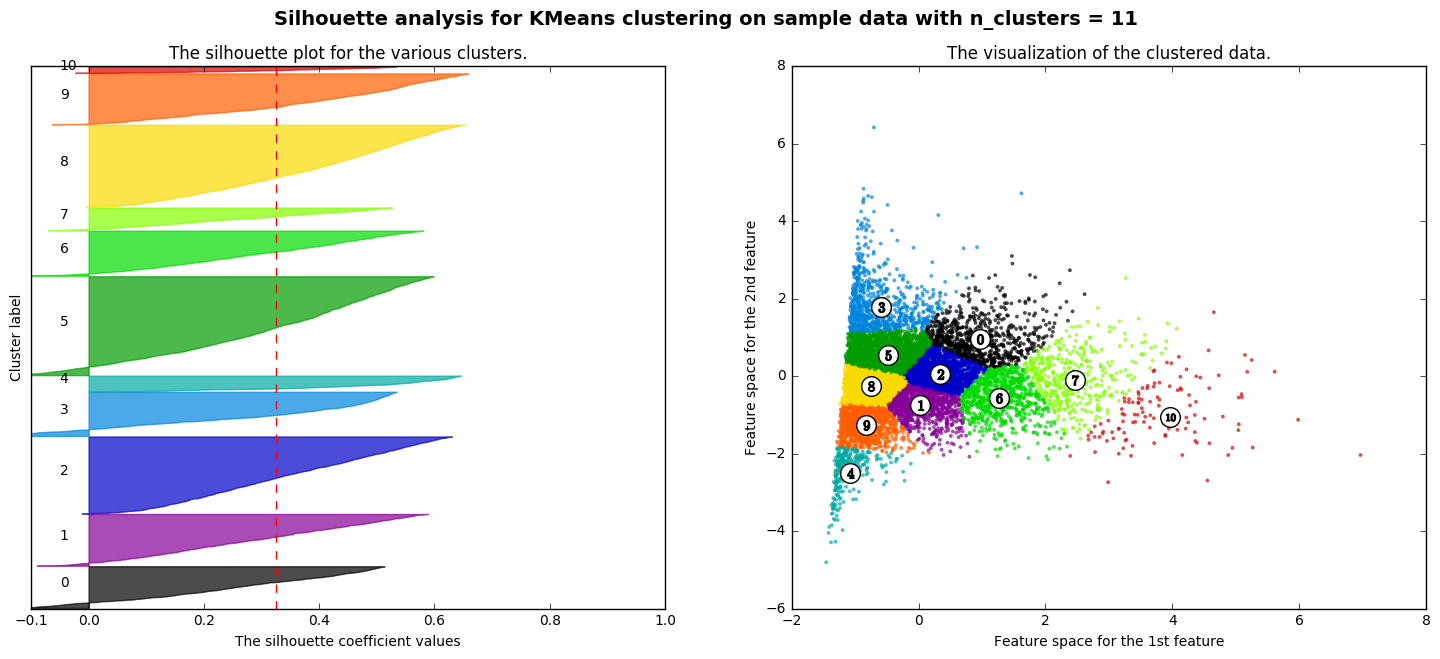

('For n_clusters =', 12, 'The average silhouette_score is :', 0.32025257208286151)


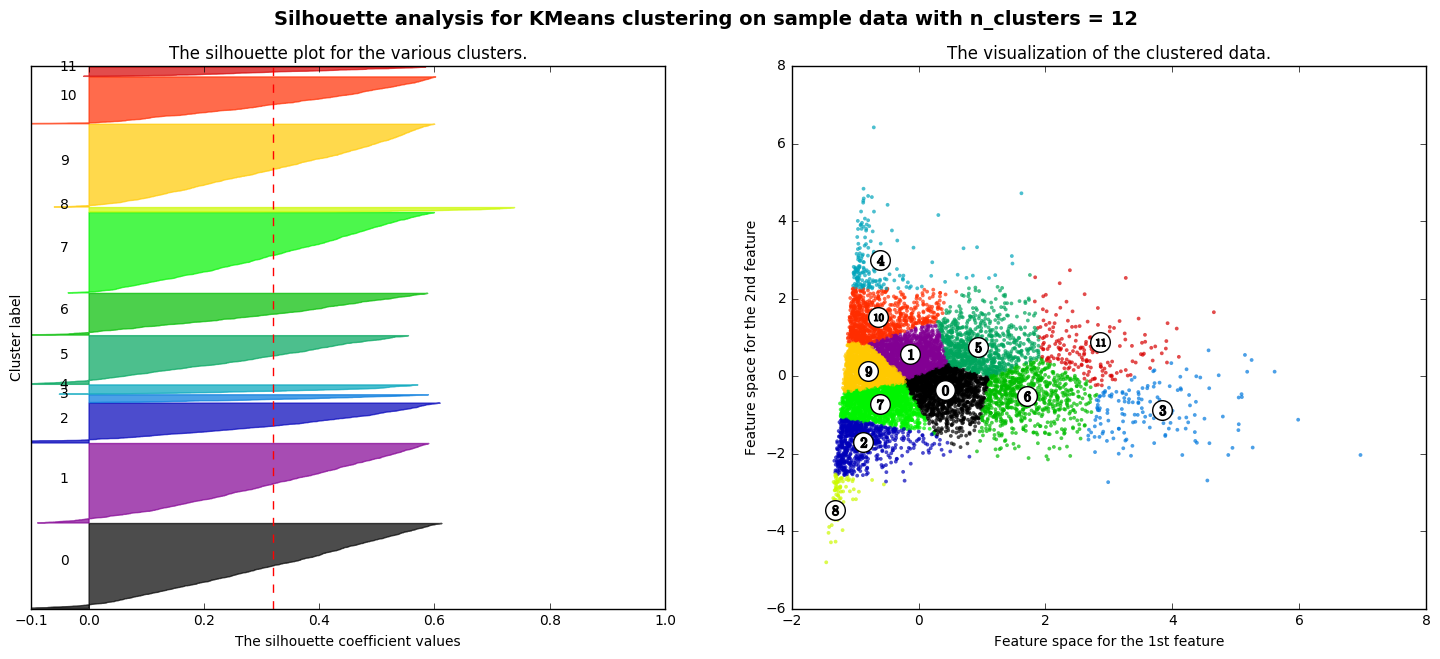

In [40]:
range_n_clusters = range(7, 13)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MiniBatchKMeans(init='k-means++', n_clusters=n_clusters, batch_size=45,
                      n_init=10, max_no_improvement=10, verbose=0)

    # clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=3)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [41]:
print X[:, 0].mean()
print X[:, 1].mean()

0.00906428175046
-0.0149850286472


In [42]:
reducer.explained_variance_ratio_

array([ 0.65915578,  0.10990008])